# 2D Ising Model & Metropolis Algorithm

## 1. The Physics Model
The **Ising Model** represents magnetic spins on a grid.
* **Lattice:** $N \times N$ grid
* **Spin ($\sigma$):** Each site is either $+1$ (up) or $-1$ (down).
* **Hamiltonian (Energy):**
    $$E = -J \sum_{\langle i, j \rangle} \sigma_i \sigma_j$$
    * $J$: Interaction strength ($J>0$ is ferromagnetic). \
        For this project we can just set $J$ to 1 

    * $\langle i, j \rangle$: Sum over nearest neighbors only.
---

## 2. The Metropolis Algorithm

**Monte Carlo** method to find equilibrium states. \
Basically Simulated Annealing but without a decaying temperature. \
The $T$ parameter stays fixed throughout the entire simulation.

1.  **Initialize:** Set the grid to random configuration. \
This initial state can be parameterized by the density of -1 sites. Density 0.5 means the initial number of -1 and 1 is roughly the same
2.  **Pick Site:** Choose a random spin $\sigma_{ij}$.
3.  **Propose Flip:** Imagine flipping the spin ($\sigma_{new} = -\sigma_{old}$).
4.  **Calculate Energy Change ($\Delta E$):**
    $$\Delta E = 2 J \sigma_{old} \sum_{neighbors} \sigma_{neighbor}$$
5.  **Accept or Reject:**
    * If **$\Delta E \leq 0$** (Energy lowers/constant): **Accept** flip.
    * If **$\Delta E > 0$** (Energy rises): Accept with probability $P$:
        $$P = e^{-\frac{\Delta E}{k_B T}}$$
        (Generate random $r \in [0,1]$. If $r < P$, accept. Else, reject.)
6.  **Loop:** Repeat for some number of steps. (probably in millions, this will be a fixed number across experiments)

---

## 3. Critical Temperature ($T_c$)
The model undergoes a **Phase Transition** at a specific temperature derived by Onsager.

$$T_c \approx 2.269 \frac{J}{k_B}$$

### The Phases
| Temperature | Phase | Description |
| :--- | :--- | :--- |
| **$T < T_c$** | **Ordered** | Ferromagnetic. Spins align. Non-zero magnetization. |
| **$T \approx T_c$** | **Critical** | Scale invariance. Fractal clusters of all sizes. Infinite correlation length. |
| **$T > T_c$** | **Disordered**| Paramagnetic. Random noise. Zero net magnetization. |

### Implementation of a sequential algorithm

In [4]:
import numpy as np


def avg_magnetization(grid: np.ndarray) -> int:
    return np.abs(np.sum(grid)) / np.prod(grid.shape)


def compute_delta_E(lattice, i, j, N: int, J: float):
    spin = lattice[i, j]
    neighbor_sum = (
        lattice[(i + 1) % N, j] +
        lattice[(i - 1) % N, j] +
        lattice[i, (j + 1) % N] +
        lattice[i, (j - 1) % N]
    )
    return 2 * J * spin * neighbor_sum

def metropolis_step(grid: np.ndarray, i: int, j: int, beta: float, N: int, J: float) -> None:
    dE = compute_delta_E(grid, i, j, N, J)
    
    if dE <= 0:
        grid[i, j] *= -1
    elif np.random.random() < np.exp(-dE * beta):
        grid[i, j] *= -1

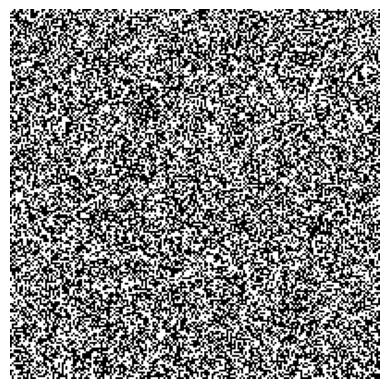

In [5]:
import matplotlib.pyplot as plt

N = 200                 # Grid size (N x N)
J = 1.0                 # Interaction strength
kT = 2.3                # Temperature (2.3 for critical)
beta = 1 / kT           # Temperature inverse
STEPS = 1_000_000         # Burn-in steps
MEASURE_STEPS = 100_000  # Fluctuation steps
density = 0.5           # density of white pixels

# Animation settings
ANIMATION_SKIP = 2000
FPS = 30

# np.random.seed(0) # Deterministic initial state
lattice = np.random.choice([1, -1], size=(N, N), p=[density, 1 - density])

plt.imshow(lattice, cmap="grey")
plt.axis("off")
plt.show()

In [6]:
from matplotlib import animation
from matplotlib.image import AxesImage

class Visualization:
    def __init__(self, animation_skip: int):
        self.animation_skip = animation_skip
        self.frames = []

    def animation_step(self, step: int, lattice: np.ndarray) -> None:
        if step % self.animation_skip == 0:
            self.frames.append((lattice.copy(), step))

    def gather_frames(self) -> list[tuple[AxesImage, int]]:
        ax_anim = plt.axes()
        ax_anim.set_axis_off()
        ax_anim.set_title(f"Ising Evolution T={kT}")

        artists = []
        for frame_data, step in self.frames:

            img = ax_anim.imshow(frame_data, cmap='gray', interpolation='nearest', animated=True)
            text = ax_anim.text(
                0.5, -0.05, f"Step: {step} / {len(self.frames * self.animation_skip)}", 
                transform=ax_anim.transAxes, 
                ha="center", 
                color="black",
                fontsize=12
            )
            
            artists.append((img, text))
        
        return artists
            

    def generate_gif(self, gif_path: str) -> None:
        print("Generating GIF animation...")

        fig_anim = plt.figure(figsize=(5, 5))
        artists = self.gather_frames()

        ani = animation.ArtistAnimation(fig_anim, artists, interval=50, blit=True, repeat_delay=1000)
        gif_filename = f"gifs/{gif_path}"
        ani.save(gif_filename, writer='pillow', fps=20)

        print(f"GIF saved successfully as: {gif_filename}")
        plt.close(fig_anim)


    def generate_mp4(self, video_path: str) -> None:
        print("Generating MP4 video...")

        fig_anim = plt.figure(figsize=(5, 5))

        artists = self.gather_frames()
        writer = animation.FFMpegWriter(fps=FPS, metadata=dict(artist='Me'), bitrate=1800)

        ani = animation.ArtistAnimation(fig_anim, artists, interval=1000/FPS, blit=False)
        video_filename = f"videos/{video_path}"
        ani.save(video_filename, writer=writer)

        print(f"Video saved successfully as: {video_filename}")
        plt.close(fig_anim)


visualizer = Visualization(ANIMATION_SKIP)


for step in range(STEPS):
    i, j = np.random.randint(0, N), np.random.randint(0, N)
    metropolis_step(lattice, i, j, beta, N, J)
    visualizer.animation_step(step, lattice)

magnetizations = []

for step in range(MEASURE_STEPS):
    i, j = np.random.randint(0, N), np.random.randint(0, N)
    metropolis_step(lattice, i, j, beta, N, J)
    visualizer.animation_step(step, lattice)
    magnetizations.append(avg_magnetization(lattice))

visualizer.generate_gif("gif1.gif")

Generating GIF animation...
GIF saved successfully as: gifs/gif1.gif


In [38]:
visualizer.generate_mp4("mp4_1.mp4")

Generating MP4 video...
Video saved successfully as: videos/mp4_1.mp4


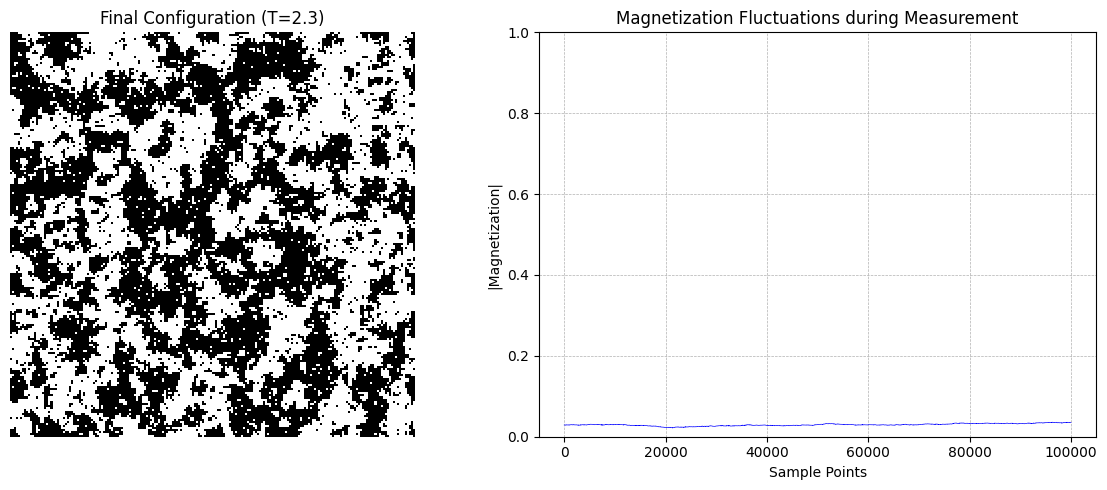

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(lattice, cmap='gray', interpolation='nearest')
ax1.set_title(f"Final Configuration (T={kT})")
ax1.axis('off')

ax2.plot(magnetizations, linewidth=0.5, color='blue')
ax2.set_title(f"Magnetization Fluctuations during Measurement")
ax2.set_xlabel("Sample Points")
ax2.set_ylabel("|Magnetization|")
ax2.set_ylim(0, 1)
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

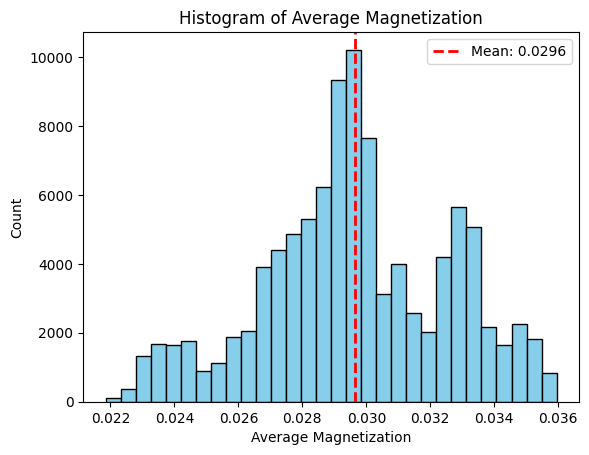

In [8]:

mean_magnetization = np.mean(magnetizations)
plt.hist(magnetizations, bins=30, color='skyblue', edgecolor='black')

plt.axvline(mean_magnetization, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_magnetization:.4f}')

plt.title("Histogram of Average Magnetization")
plt.xlabel("Average Magnetization")
plt.ylabel("Count")
plt.legend()
plt.show()